# Test reconstruct_audio_from_ai Function

Notebook này test hàm `reconstruct_audio_from_ai` với dữ liệu từ 3 file audio:
- **Original Audio**: `20250723_224740_05_preprocessed_for_ai.wav` (từ DSP preprocessing)
- **AI Vocals**: `20250723_224754_02a_ai_vocals_separated.wav` (từ Spleeter AI)
- **AI Accompaniment**: `20250723_224754_02b_ai_accompaniment_separated.wav` (từ Spleeter AI)

Pipeline xử lý: Load Data → Length Sync → Noise Gate → Audio Mixing → RMS Normalization → Clipping Prevention → Export Results

In [1]:
# Import Required Libraries
import datetime
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
import librosa
import librosa.display

print("✓ All libraries imported successfully")
print(f"Current working directory: {os.getcwd()}")

# Set timestamp for this run
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Timestamp for this run: {timestamp}")

# Create output directory
output_dir = "output/test_reconstruct"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

✓ All libraries imported successfully
Current working directory: d:\DSP-present\fancam_noise_reduction
Timestamp for this run: 20250723_232154
Output directory: output/test_reconstruct


In [2]:
# Load Input Audio Files
print("📁 Loading input audio files...")

# File paths (adjust if files are in different location)
original_audio_file = "20250723_224740_05_preprocessed_for_ai.wav"
vocals_file = "20250723_224754_02a_ai_vocals_separated.wav"
accompaniment_file = "20250723_224754_02b_ai_accompaniment_separated.wav"

try:
    # Load original audio (từ DSP preprocessing)
    original_audio, sr = sf.read(original_audio_file)
    print(f"✓ Original audio loaded: {original_audio_file}")
    print(f"  Shape: {original_audio.shape}, Duration: {len(original_audio)/sr:.2f}s")
    
    # Load AI-separated vocals
    vocals, sr_vocals = sf.read(vocals_file)
    if len(vocals.shape) == 2:  # Convert stereo to mono if needed
        vocals = np.mean(vocals, axis=1)
    print(f"✓ Vocals loaded: {vocals_file}")
    print(f"  Shape: {vocals.shape}, Duration: {len(vocals)/sr_vocals:.2f}s")
    
    # Load AI-separated accompaniment
    accompaniment, sr_accomp = sf.read(accompaniment_file)
    if len(accompaniment.shape) == 2:  # Convert stereo to mono if needed
        accompaniment = np.mean(accompaniment, axis=1)
    print(f"✓ Accompaniment loaded: {accompaniment_file}")
    print(f"  Shape: {accompaniment.shape}, Duration: {len(accompaniment)/sr_accomp:.2f}s")
    
    # Verify sample rates match
    if sr != sr_vocals or sr != sr_accomp:
        print(f"⚠️  Warning: Sample rate mismatch - Original: {sr}, Vocals: {sr_vocals}, Accompaniment: {sr_accomp}")
    else:
        print(f"✓ All sample rates match: {sr} Hz")
    
    # Create separated_audio dict (như trong original function)
    separated_audio = {
        'vocals': vocals,
        'accompaniment': accompaniment
    }
    print(f"✓ Created separated_audio dict with keys: {list(separated_audio.keys())}")
    
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
    print("Please make sure all audio files are in the current directory")
except Exception as e:
    print(f"❌ Error loading files: {e}")

📁 Loading input audio files...
✓ Original audio loaded: 20250723_224740_05_preprocessed_for_ai.wav
  Shape: (887296,), Duration: 40.24s
✓ Vocals loaded: 20250723_224754_02a_ai_vocals_separated.wav
  Shape: (887296,), Duration: 40.24s
✓ Accompaniment loaded: 20250723_224754_02b_ai_accompaniment_separated.wav
  Shape: (887296,), Duration: 40.24s
✓ All sample rates match: 22050 Hz
✓ Created separated_audio dict with keys: ['vocals', 'accompaniment']


In [4]:
# Data Validation and Length Synchronization
print("🔧 Validating data and synchronizing lengths...")

# Step 1: Validation
if not isinstance(vocals, np.ndarray):
    raise TypeError(f"Vocals must be numpy.ndarray, got {type(vocals)}")
if not isinstance(accompaniment, np.ndarray):
    raise TypeError(f"Accompaniment must be numpy.ndarray, got {type(accompaniment)}")
if not isinstance(original_audio, np.ndarray):
    raise TypeError(f"Original audio must be numpy.ndarray, got {type(original_audio)}")

print(f"✓ All data types validated as numpy arrays")

# Export step 1: Original loaded data
sf.write(f"{output_dir}/{timestamp}_step01_original_vocals.wav", vocals, sr)
sf.write(f"{output_dir}/{timestamp}_step01_original_accompaniment.wav", accompaniment, sr)
sf.write(f"{output_dir}/{timestamp}_step01_original_audio.wav", original_audio, sr)
print(f"✓ Exported step 1 files - Original loaded data")

print(f"\nLength comparison before sync:")
print(f"  Original audio: {len(original_audio)} samples")
print(f"  Vocals: {len(vocals)} samples")
print(f"  Accompaniment: {len(accompaniment)} samples")

# Step 2: Length synchronization for vocals
if len(vocals) != len(original_audio):
    print(f"🔄 Synchronizing vocals length...")
    if len(vocals) > len(original_audio):
        vocals = vocals[:len(original_audio)]
        print(f"  Truncated vocals to {len(vocals)} samples")
    else:
        vocals = np.pad(vocals, (0, len(original_audio) - len(vocals)))
        print(f"  Padded vocals to {len(vocals)} samples")

# Step 3: Length synchronization for accompaniment  
if len(accompaniment) != len(original_audio):
    print(f"🔄 Synchronizing accompaniment length...")
    if len(accompaniment) > len(original_audio):
        accompaniment = accompaniment[:len(original_audio)]
        print(f"  Truncated accompaniment to {len(accompaniment)} samples")
    else:
        accompaniment = np.pad(accompaniment, (0, len(original_audio) - len(accompaniment)))
        print(f"  Padded accompaniment to {len(accompaniment)} samples")

print(f"\nLength comparison after sync:")
print(f"  Original audio: {len(original_audio)} samples")
print(f"  Vocals: {len(vocals)} samples")
print(f"  Accompaniment: {len(accompaniment)} samples")

# Export step 2: After length synchronization
sf.write(f"{output_dir}/{timestamp}_step02_synced_vocals.wav", vocals, sr)
sf.write(f"{output_dir}/{timestamp}_step02_synced_accompaniment.wav", accompaniment, sr)
print(f"✓ Exported step 2 files - Length synchronized")

🔧 Validating data and synchronizing lengths...
✓ All data types validated as numpy arrays
✓ Exported step 1 files - Original loaded data

Length comparison before sync:
  Original audio: 887296 samples
  Vocals: 887296 samples
  Accompaniment: 887296 samples

Length comparison after sync:
  Original audio: 887296 samples
  Vocals: 887296 samples
  Accompaniment: 887296 samples
✓ Exported step 2 files - Length synchronized


📊 Calculating RMS and noise gate threshold...
Vocals RMS: 0.094349
Gate threshold: 0.000488

Threshold calculation breakdown:
  1% of RMS: 0.000943
  2% of RMS: 0.001887
  Minimum threshold: 0.000100
  Final threshold (max of above): 0.000488

Noise gate impact analysis:
  Total samples: 887,296
  Samples below threshold: 88,935 (10.0%)
  Samples above threshold: 798,361 (90.0%)


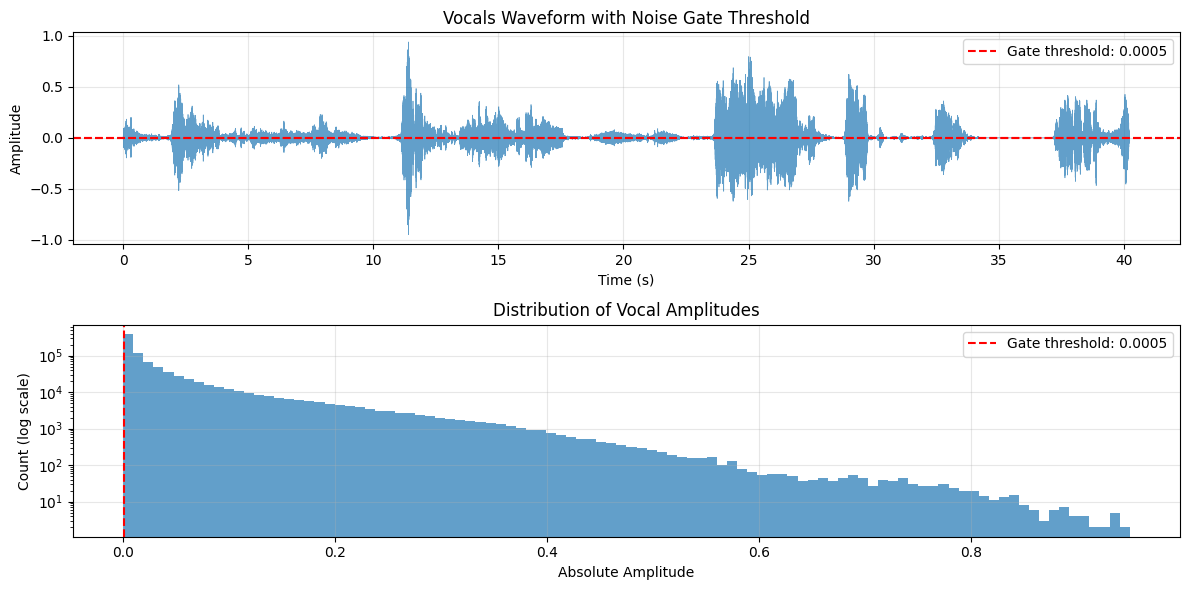

✓ RMS analysis completed and visualization saved


In [13]:
# Calculate RMS and Noise Gate Threshold
print("📊 Calculating RMS and noise gate threshold...")

# Step 3: Calculate RMS of vocals
vocals_rms = np.sqrt(np.mean(vocals**2))
print(f"Vocals RMS: {vocals_rms:.6f}")

# Calculate noise gate threshold using the same logic as original function
threshold_percentile = np.percentile(np.abs(vocals), 10)  # 5th percentile
gate_threshold = min(threshold_percentile, vocals_rms * 0.1)  # Maximum 0.5% of RMS
print(f"Gate threshold: {gate_threshold:.6f}")

# Analysis of threshold components
threshold_1percent = vocals_rms * 0.01
threshold_2percent = vocals_rms * 0.02
minimum_threshold = 0.0001

print(f"\nThreshold calculation breakdown:")
print(f"  1% of RMS: {threshold_1percent:.6f}")
print(f"  2% of RMS: {threshold_2percent:.6f}")
print(f"  Minimum threshold: {minimum_threshold:.6f}")
print(f"  Final threshold (max of above): {gate_threshold:.6f}")

# Calculate how many samples will be affected
samples_below_threshold = np.sum(np.abs(vocals) <= gate_threshold)
samples_above_threshold = np.sum(np.abs(vocals) > gate_threshold)
percentage_below = (samples_below_threshold / len(vocals)) * 100

print(f"\nNoise gate impact analysis:")
print(f"  Total samples: {len(vocals):,}")
print(f"  Samples below threshold: {samples_below_threshold:,} ({percentage_below:.1f}%)")
print(f"  Samples above threshold: {samples_above_threshold:,} ({100-percentage_below:.1f}%)")

# Visualize RMS and threshold
plt.figure(figsize=(12, 6))

# Plot 1: Vocals waveform with threshold lines
plt.subplot(2, 1, 1)
time_axis = np.linspace(0, len(vocals)/sr, len(vocals))
plt.plot(time_axis, vocals, alpha=0.7, linewidth=0.5)
plt.axhline(y=gate_threshold, color='red', linestyle='--', label=f'Gate threshold: {gate_threshold:.4f}')
plt.axhline(y=-gate_threshold, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Vocals Waveform with Noise Gate Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of absolute values
plt.subplot(2, 1, 2)
abs_vocals = np.abs(vocals)
plt.hist(abs_vocals, bins=100, alpha=0.7, log=True)
plt.axvline(x=gate_threshold, color='red', linestyle='--', label=f'Gate threshold: {gate_threshold:.4f}')
plt.xlabel('Absolute Amplitude')
plt.ylabel('Count (log scale)')
plt.title('Distribution of Vocal Amplitudes')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/{timestamp}_step03_rms_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ RMS analysis completed and visualization saved")

🔇 Applying noise gate to vocals...
✓ Exported step 4 file - Noise gated vocals

Noise gate results:
  Samples below threshold (gated to 0): 160,630 (18.1%)
  Samples above threshold (preserved): 726,666 (81.9%)

RMS comparison:
  Before gating: 0.094349
  After gating: 0.094349
  RMS reduction: 0.0%


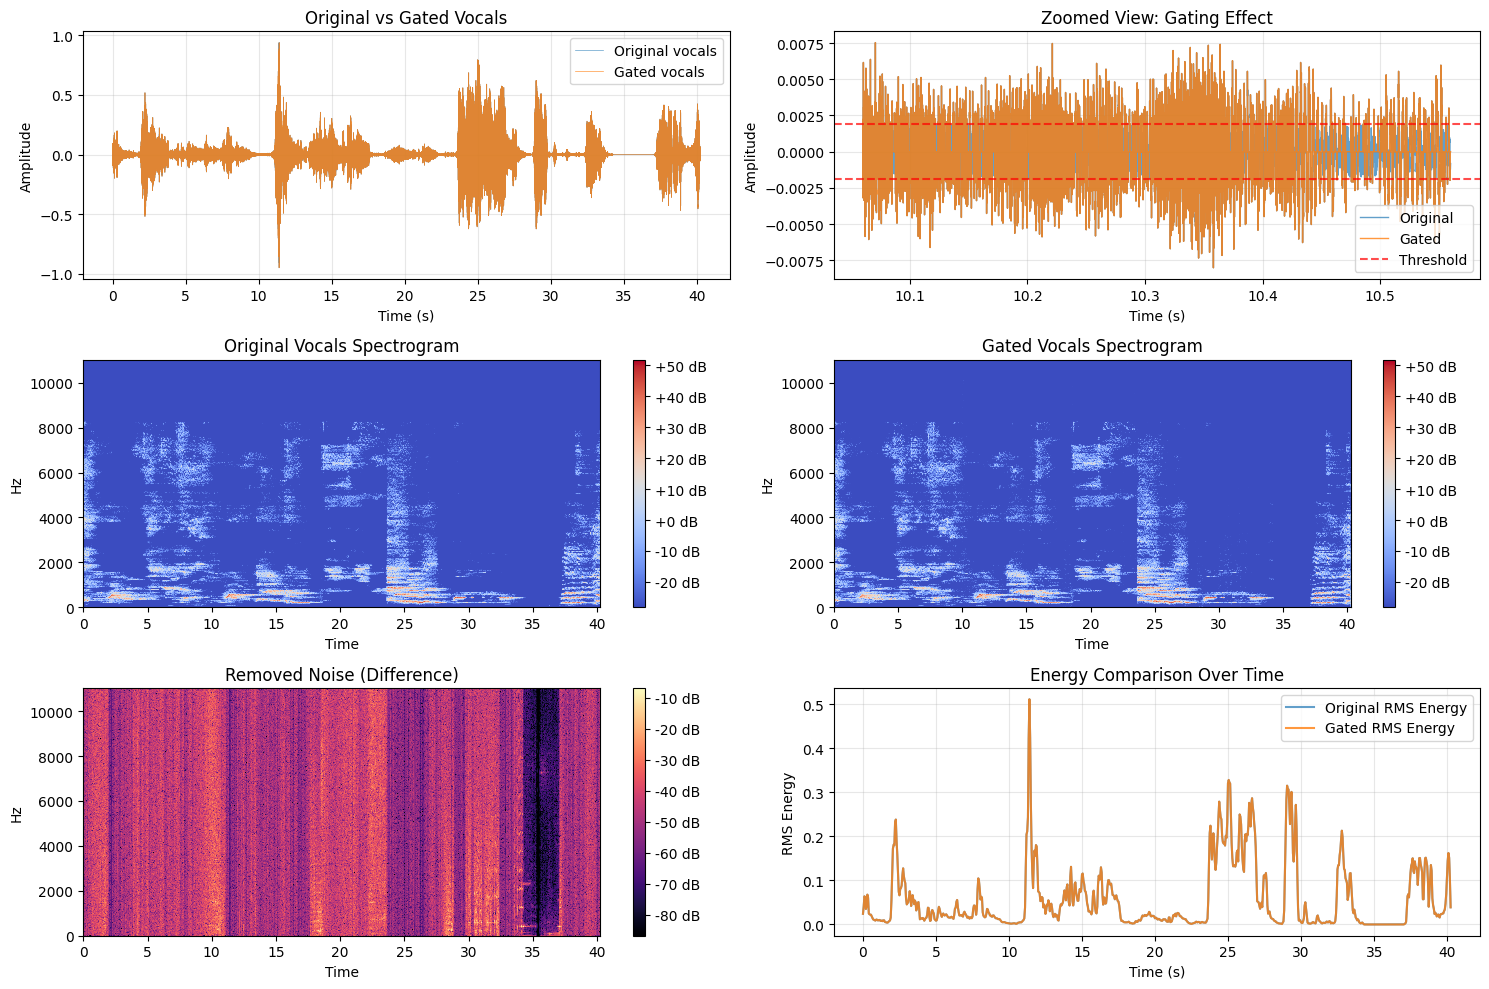

✓ Noise gate analysis completed and visualizations saved


In [6]:
# Apply Noise Gate to Vocals
print("🔇 Applying noise gate to vocals...")

# Step 4: Apply Noise Gate using the same logic as original function
gated_vocals = np.where(np.abs(vocals) > gate_threshold, vocals, 0.0)

# Export gated vocals
sf.write(f"{output_dir}/{timestamp}_step04_gated_vocals.wav", gated_vocals, sr)
print(f"✓ Exported step 4 file - Noise gated vocals")

# Debug info về noise gate (same as original)
below_threshold = np.sum(np.abs(vocals) <= gate_threshold)
above_threshold = np.sum(np.abs(vocals) > gate_threshold)
percentage_gated = (below_threshold / len(vocals)) * 100

print(f"\nNoise gate results:")
print(f"  Samples below threshold (gated to 0): {below_threshold:,} ({percentage_gated:.1f}%)")
print(f"  Samples above threshold (preserved): {above_threshold:,} ({100-percentage_gated:.1f}%)")

# Calculate RMS before and after gating
vocals_rms_before = np.sqrt(np.mean(vocals**2))
gated_vocals_rms = np.sqrt(np.mean(gated_vocals**2))
rms_reduction = ((vocals_rms_before - gated_vocals_rms) / vocals_rms_before) * 100

print(f"\nRMS comparison:")
print(f"  Before gating: {vocals_rms_before:.6f}")
print(f"  After gating: {gated_vocals_rms:.6f}")
print(f"  RMS reduction: {rms_reduction:.1f}%")

# Visualize the effect of noise gating
plt.figure(figsize=(15, 10))

# Plot 1: Original vs Gated vocals (time domain)
plt.subplot(3, 2, 1)
time_axis = np.linspace(0, len(vocals)/sr, len(vocals))
plt.plot(time_axis, vocals, alpha=0.7, label='Original vocals', linewidth=0.5)
plt.plot(time_axis, gated_vocals, alpha=0.8, label='Gated vocals', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Gated Vocals')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoom in on a small section to see gating effect
plt.subplot(3, 2, 2)
start_sample = len(vocals) // 4
end_sample = start_sample + sr // 2  # 0.5 second window
time_zoom = time_axis[start_sample:end_sample]
plt.plot(time_zoom, vocals[start_sample:end_sample], alpha=0.7, label='Original', linewidth=1)
plt.plot(time_zoom, gated_vocals[start_sample:end_sample], alpha=0.8, label='Gated', linewidth=1)
plt.axhline(y=gate_threshold, color='red', linestyle='--', alpha=0.7, label='Threshold')
plt.axhline(y=-gate_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: Gating Effect')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Spectrogram comparison - Original
plt.subplot(3, 2, 3)
D_orig = librosa.stft(vocals)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_orig)), sr=sr, x_axis='time', y_axis='hz')
plt.title('Original Vocals Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot 4: Spectrogram comparison - Gated
plt.subplot(3, 2, 4)
D_gated = librosa.stft(gated_vocals)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_gated)), sr=sr, x_axis='time', y_axis='hz')
plt.title('Gated Vocals Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot 5: Difference spectrogram (what was removed)
plt.subplot(3, 2, 5)
difference = vocals - gated_vocals
D_diff = librosa.stft(difference)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_diff) + 1e-10), sr=sr, x_axis='time', y_axis='hz')
plt.title('Removed Noise (Difference)')
plt.colorbar(format='%+2.0f dB')

# Plot 6: Energy comparison over time
plt.subplot(3, 2, 6)
frame_length = sr // 10  # 0.1 second frames
hop_length = frame_length // 2
energy_orig = librosa.feature.rms(y=vocals, frame_length=frame_length, hop_length=hop_length)[0]
energy_gated = librosa.feature.rms(y=gated_vocals, frame_length=frame_length, hop_length=hop_length)[0]
time_frames = librosa.frames_to_time(range(len(energy_orig)), sr=sr, hop_length=hop_length)

plt.plot(time_frames, energy_orig, label='Original RMS Energy', alpha=0.7)
plt.plot(time_frames, energy_gated, label='Gated RMS Energy', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.title('Energy Comparison Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/{timestamp}_step04_noise_gate_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Noise gate analysis completed and visualizations saved")

🎵 Mixing audio components...
Audio mixing parameters:
  Vocals weight: 0.9
  Accompaniment weight: 0.1
✓ Exported step 5 file - Mixed audio

Mixing analysis:
  Gated vocals RMS: 0.094349
  Accompaniment RMS: 0.135787
  Mixed audio RMS: 0.086895

Weighted contributions:
  Vocals contribution: 0.084914
  Accompaniment contribution: 0.013579


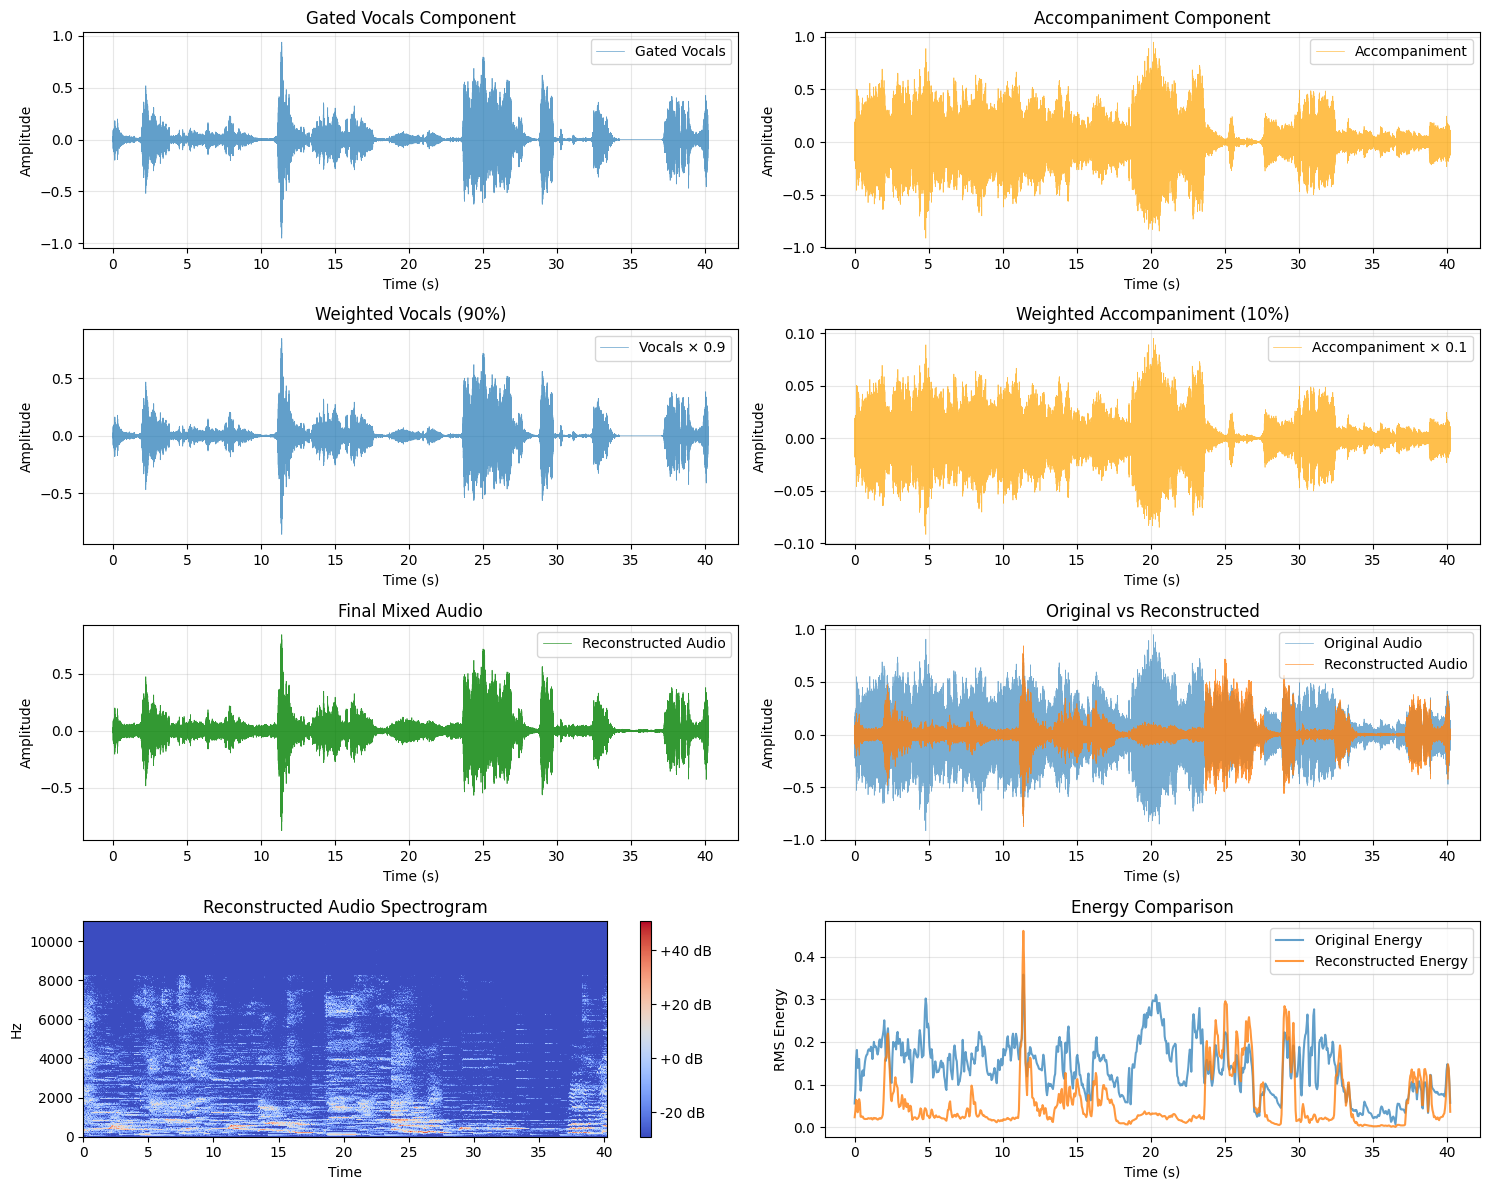

✓ Audio mixing analysis completed and visualizations saved


In [7]:
# Audio Mixing and Reconstruction
print("🎵 Mixing audio components...")

# Step 5: Audio Mixing (same weights as original function)
vocals_weight = 0.9
accompaniment_weight = 0.1

reconstructed_audio = gated_vocals * vocals_weight + accompaniment * accompaniment_weight

print(f"Audio mixing parameters:")
print(f"  Vocals weight: {vocals_weight}")
print(f"  Accompaniment weight: {accompaniment_weight}")

# Export mixed audio
sf.write(f"{output_dir}/{timestamp}_step05_mixed_audio.wav", reconstructed_audio, sr)
print(f"✓ Exported step 5 file - Mixed audio")

# Analysis of mixing results
mixed_rms = np.sqrt(np.mean(reconstructed_audio**2))
gated_vocals_rms = np.sqrt(np.mean(gated_vocals**2))
accompaniment_rms = np.sqrt(np.mean(accompaniment**2))

print(f"\nMixing analysis:")
print(f"  Gated vocals RMS: {gated_vocals_rms:.6f}")
print(f"  Accompaniment RMS: {accompaniment_rms:.6f}")
print(f"  Mixed audio RMS: {mixed_rms:.6f}")

# Calculate individual contributions
vocals_contribution = gated_vocals_rms * vocals_weight
accompaniment_contribution = accompaniment_rms * accompaniment_weight

print(f"\nWeighted contributions:")
print(f"  Vocals contribution: {vocals_contribution:.6f}")
print(f"  Accompaniment contribution: {accompaniment_contribution:.6f}")

# Visualize mixing results
plt.figure(figsize=(15, 12))

# Plot 1: Individual components
plt.subplot(4, 2, 1)
time_axis = np.linspace(0, len(reconstructed_audio)/sr, len(reconstructed_audio))
plt.plot(time_axis, gated_vocals, alpha=0.7, label='Gated Vocals', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Gated Vocals Component')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 2, 2)
plt.plot(time_axis, accompaniment, alpha=0.7, label='Accompaniment', color='orange', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Accompaniment Component')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Weighted components
plt.subplot(4, 2, 3)
weighted_vocals = gated_vocals * vocals_weight
plt.plot(time_axis, weighted_vocals, alpha=0.7, label=f'Vocals × {vocals_weight}', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Weighted Vocals (90%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 2, 4)
weighted_accompaniment = accompaniment * accompaniment_weight
plt.plot(time_axis, weighted_accompaniment, alpha=0.7, label=f'Accompaniment × {accompaniment_weight}', color='orange', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Weighted Accompaniment (10%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final mixed result
plt.subplot(4, 2, 5)
plt.plot(time_axis, reconstructed_audio, alpha=0.8, label='Reconstructed Audio', color='green', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Final Mixed Audio')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Comparison with original
plt.subplot(4, 2, 6)
plt.plot(time_axis, original_audio, alpha=0.6, label='Original Audio', linewidth=0.5)
plt.plot(time_axis, reconstructed_audio, alpha=0.8, label='Reconstructed Audio', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Spectrogram of reconstructed audio
plt.subplot(4, 2, 7)
D_reconstructed = librosa.stft(reconstructed_audio)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_reconstructed)), sr=sr, x_axis='time', y_axis='hz')
plt.title('Reconstructed Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot 6: Energy distribution comparison
plt.subplot(4, 2, 8)
frame_length = sr // 10
hop_length = frame_length // 2
energy_orig = librosa.feature.rms(y=original_audio, frame_length=frame_length, hop_length=hop_length)[0]
energy_recon = librosa.feature.rms(y=reconstructed_audio, frame_length=frame_length, hop_length=hop_length)[0]
time_frames = librosa.frames_to_time(range(len(energy_orig)), sr=sr, hop_length=hop_length)

plt.plot(time_frames, energy_orig, label='Original Energy', alpha=0.7)
plt.plot(time_frames, energy_recon, label='Reconstructed Energy', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.title('Energy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/{timestamp}_step05_mixing_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Audio mixing analysis completed and visualizations saved")

⚖️ Applying RMS normalization...
RMS comparison:
  Original RMS: 0.152969
  Current RMS: 0.086895
  RMS ratio: 0.568
✓ RMS ratio within acceptable bounds (0.5-2.0), no normalization needed


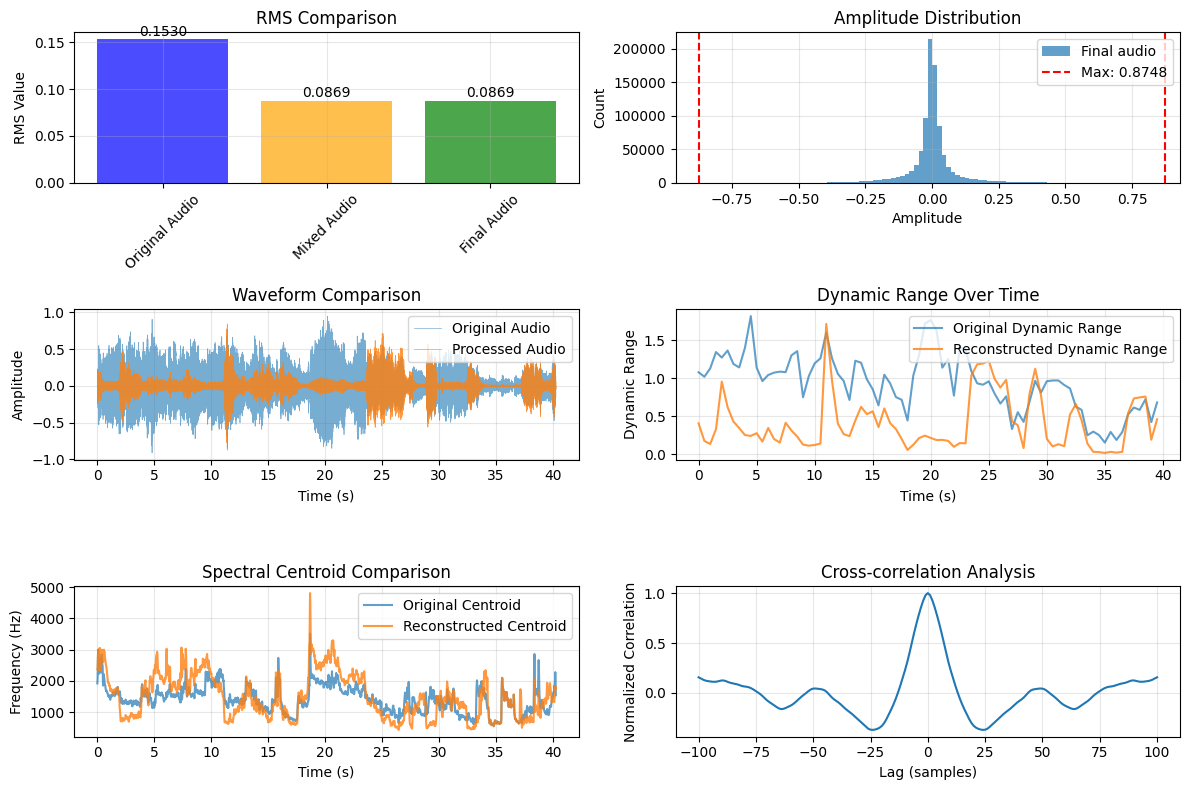

✓ RMS normalization analysis completed and visualizations saved


In [8]:
# RMS Normalization
print("⚖️ Applying RMS normalization...")

# Step 6: RMS Normalization (exact same logic as original function)
original_rms = np.sqrt(np.mean(original_audio**2))
current_rms = np.sqrt(np.mean(reconstructed_audio**2))

print(f"RMS comparison:")
print(f"  Original RMS: {original_rms:.6f}")
print(f"  Current RMS: {current_rms:.6f}")

normalization_applied = False
if current_rms > 0 and original_rms > 0:
    ratio = current_rms / original_rms
    print(f"  RMS ratio: {ratio:.3f}")
    
    # Apply normalization if ratio is outside acceptable bounds (same as original)
    if ratio < 0.5 or ratio > 2.0:
        target_rms = original_rms * 0.95  # Same target as original
        normalization_gain = target_rms / current_rms
        reconstructed_audio = reconstructed_audio * normalization_gain
        normalization_applied = True
        
        print(f"🔧 Normalization applied:")
        print(f"  Target RMS: {target_rms:.6f}")
        print(f"  Normalization gain: {normalization_gain:.3f}")
        
        # Export normalized audio
        sf.write(f"{output_dir}/{timestamp}_step06_normalized_audio.wav", reconstructed_audio, sr)
        print(f"✓ Exported step 6 file - RMS normalized audio")
        
        # Verify normalization
        new_rms = np.sqrt(np.mean(reconstructed_audio**2))
        print(f"  Final RMS after normalization: {new_rms:.6f}")
    else:
        print(f"✓ RMS ratio within acceptable bounds (0.5-2.0), no normalization needed")
else:
    print(f"⚠️  Cannot calculate ratio - zero RMS detected")

# Visualize RMS normalization effects
plt.figure(figsize=(12, 8))

# Plot 1: RMS comparison
plt.subplot(3, 2, 1)
rms_labels = ['Original Audio', 'Mixed Audio', 'After Normalization' if normalization_applied else 'Final Audio']
rms_values = [original_rms, current_rms, np.sqrt(np.mean(reconstructed_audio**2))]
colors = ['blue', 'orange', 'green']

bars = plt.bar(rms_labels, rms_values, color=colors, alpha=0.7)
plt.ylabel('RMS Value')
plt.title('RMS Comparison')
plt.xticks(rotation=45)
for bar, value in zip(bars, rms_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{value:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Plot 2: Amplitude distribution before and after normalization
plt.subplot(3, 2, 2)
plt.hist(reconstructed_audio, bins=100, alpha=0.7, label='After normalization' if normalization_applied else 'Final audio')
max_val = np.max(np.abs(reconstructed_audio))
plt.axvline(x=max_val, color='red', linestyle='--', label=f'Max: {max_val:.4f}')
plt.axvline(x=-max_val, color='red', linestyle='--')
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.title('Amplitude Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Time domain comparison
plt.subplot(3, 2, 3)
time_axis = np.linspace(0, len(reconstructed_audio)/sr, len(reconstructed_audio))
plt.plot(time_axis, original_audio, alpha=0.6, label='Original Audio', linewidth=0.5)
plt.plot(time_axis, reconstructed_audio, alpha=0.8, label='Processed Audio', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Dynamic range comparison
plt.subplot(3, 2, 4)
window_size = sr // 2  # 0.5 second windows
num_windows = len(original_audio) // window_size
orig_dynamics = []
recon_dynamics = []

for i in range(num_windows):
    start = i * window_size
    end = start + window_size
    orig_window = original_audio[start:end]
    recon_window = reconstructed_audio[start:end]
    
    orig_dynamics.append(np.max(orig_window) - np.min(orig_window))
    recon_dynamics.append(np.max(recon_window) - np.min(recon_window))

window_times = np.arange(num_windows) * 0.5
plt.plot(window_times, orig_dynamics, alpha=0.7, label='Original Dynamic Range')
plt.plot(window_times, recon_dynamics, alpha=0.8, label='Reconstructed Dynamic Range')
plt.xlabel('Time (s)')
plt.ylabel('Dynamic Range')
plt.title('Dynamic Range Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Spectral centroid comparison
plt.subplot(3, 2, 5)
centroid_orig = librosa.feature.spectral_centroid(y=original_audio, sr=sr)[0]
centroid_recon = librosa.feature.spectral_centroid(y=reconstructed_audio, sr=sr)[0]
time_frames = librosa.frames_to_time(range(len(centroid_orig)), sr=sr)

plt.plot(time_frames, centroid_orig, alpha=0.7, label='Original Centroid')
plt.plot(time_frames, centroid_recon, alpha=0.8, label='Reconstructed Centroid')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Correlation analysis
plt.subplot(3, 2, 6)
correlation = np.correlate(original_audio, reconstructed_audio, mode='full')
correlation = correlation / np.max(correlation)  # Normalize
lags = np.arange(-len(reconstructed_audio) + 1, len(original_audio))
center_idx = len(correlation) // 2
correlation_zoom = correlation[center_idx-100:center_idx+101]
lags_zoom = lags[center_idx-100:center_idx+101]

plt.plot(lags_zoom, correlation_zoom)
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Correlation')
plt.title('Cross-correlation Analysis')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/{timestamp}_step06_normalization_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ RMS normalization analysis completed and visualizations saved")

✂️ Applying clipping prevention...
Max absolute value before clipping check: 0.874789
✓ No clipping prevention needed (max ≤ 0.9)
✓ Exported step 7 file - Final reconstructed audio

Final audio statistics:
  Final RMS: 0.086895
  Final Max: 0.874789


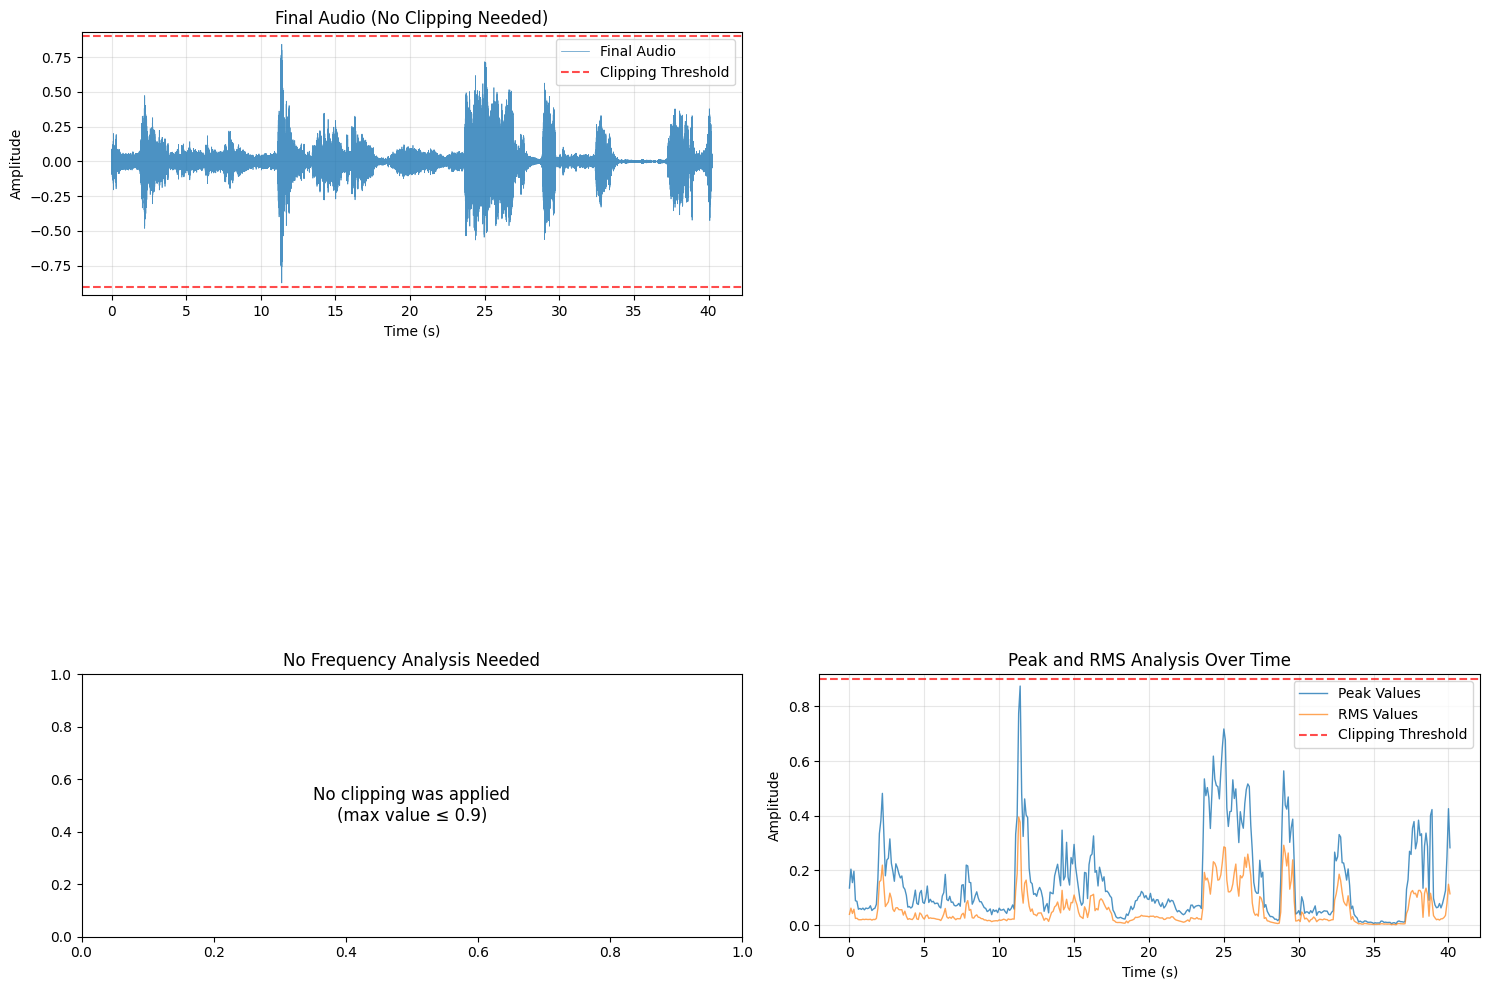

✓ Clipping prevention analysis completed and visualizations saved


In [9]:
# Clipping Prevention
print("✂️ Applying clipping prevention...")

# Step 7: Clipping Prevention (exact same logic as original function)
max_val = np.max(np.abs(reconstructed_audio))
print(f"Max absolute value before clipping check: {max_val:.6f}")

clipping_applied = False
if max_val > 0.9:
    print(f"🔧 Clipping prevention needed (max > 0.9)")
    
    # Save audio before clipping
    reconstructed_audio_before_clipping = reconstructed_audio.copy()
    sf.write(f"{output_dir}/{timestamp}_step07a_before_clipping.wav", reconstructed_audio_before_clipping, sr)
    print(f"✓ Exported step 7a file - Before clipping")
    
    # Apply soft clipping using tanh (same as original)
    reconstructed_audio = np.tanh(reconstructed_audio * 0.9) * 0.8
    clipping_applied = True
    
    new_max_val = np.max(np.abs(reconstructed_audio))
    print(f"  Max value after soft clipping: {new_max_val:.6f}")
    print(f"  Clipping parameters: input_scale=0.9, output_scale=0.8")
else:
    print(f"✓ No clipping prevention needed (max ≤ 0.9)")

# Export final result
sf.write(f"{output_dir}/{timestamp}_step07_final_result.wav", reconstructed_audio, sr)
print(f"✓ Exported step 7 file - Final reconstructed audio")

# Final debug info (same as original function)
final_rms = np.sqrt(np.mean(reconstructed_audio**2))
final_max = np.max(np.abs(reconstructed_audio))
print(f"\nFinal audio statistics:")
print(f"  Final RMS: {final_rms:.6f}")
print(f"  Final Max: {final_max:.6f}")

# Visualize clipping prevention effects
plt.figure(figsize=(15, 10))

if clipping_applied:
    # Plot 1: Before vs After clipping
    plt.subplot(3, 2, 1)
    time_axis = np.linspace(0, len(reconstructed_audio)/sr, len(reconstructed_audio))
    plt.plot(time_axis, reconstructed_audio_before_clipping, alpha=0.7, label='Before Clipping', linewidth=0.5)
    plt.plot(time_axis, reconstructed_audio, alpha=0.8, label='After Soft Clipping', linewidth=0.5)
    plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
    plt.axhline(y=-0.9, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Before vs After Clipping')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Amplitude distribution comparison
    plt.subplot(3, 2, 2)
    plt.hist(reconstructed_audio_before_clipping, bins=100, alpha=0.6, label='Before Clipping', density=True)
    plt.hist(reconstructed_audio, bins=100, alpha=0.7, label='After Clipping', density=True)
    plt.axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
    plt.axvline(x=-0.9, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Amplitude')
    plt.ylabel('Density')
    plt.title('Amplitude Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Tanh transfer function
    plt.subplot(3, 2, 3)
    x = np.linspace(-2, 2, 1000)
    y_linear = x
    y_tanh = np.tanh(x * 0.9) * 0.8
    plt.plot(x, y_linear, label='Linear (no clipping)', alpha=0.7)
    plt.plot(x, y_tanh, label='Tanh soft clipping', alpha=0.8)
    plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Hard clip threshold')
    plt.axhline(y=-0.9, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Input Amplitude')
    plt.ylabel('Output Amplitude')
    plt.title('Soft Clipping Transfer Function')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Zoom on clipped regions
    plt.subplot(3, 2, 4)
    # Find regions where clipping occurred
    clipped_mask = np.abs(reconstructed_audio_before_clipping) > 0.9
    if np.any(clipped_mask):
        clipped_indices = np.where(clipped_mask)[0]
        if len(clipped_indices) > 0:
            # Show first clipped region
            start_idx = max(0, clipped_indices[0] - 100)
            end_idx = min(len(reconstructed_audio), clipped_indices[0] + 100)
            time_zoom = time_axis[start_idx:end_idx]
            plt.plot(time_zoom, reconstructed_audio_before_clipping[start_idx:end_idx], 
                    alpha=0.7, label='Before Clipping', linewidth=1)
            plt.plot(time_zoom, reconstructed_audio[start_idx:end_idx], 
                    alpha=0.8, label='After Clipping', linewidth=1)
            plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7)
            plt.axhline(y=-0.9, color='red', linestyle='--', alpha=0.7)
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.title('Zoomed View: Clipped Region')
            plt.legend()
            plt.grid(True, alpha=0.3)
else:
    # Show that no clipping was needed
    plt.subplot(3, 2, 1)
    time_axis = np.linspace(0, len(reconstructed_audio)/sr, len(reconstructed_audio))
    plt.plot(time_axis, reconstructed_audio, alpha=0.8, label='Final Audio', linewidth=0.5)
    plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
    plt.axhline(y=-0.9, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Final Audio (No Clipping Needed)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot 5: THD analysis (if clipping was applied)
plt.subplot(3, 2, 5)
if clipping_applied:
    # Calculate Total Harmonic Distortion
    from scipy import fft
    freq_before = fft.fftfreq(len(reconstructed_audio_before_clipping), 1/sr)[:len(reconstructed_audio_before_clipping)//2]
    fft_before = np.abs(fft.fft(reconstructed_audio_before_clipping))[:len(reconstructed_audio_before_clipping)//2]
    fft_after = np.abs(fft.fft(reconstructed_audio))[:len(reconstructed_audio)//2]
    
    plt.semilogy(freq_before, fft_before, alpha=0.7, label='Before Clipping')
    plt.semilogy(freq_before, fft_after, alpha=0.8, label='After Clipping')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Domain Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, sr//2)
else:
    plt.text(0.5, 0.5, 'No clipping was applied\n(max value ≤ 0.9)', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('No Frequency Analysis Needed')

# Plot 6: Peak analysis over time
plt.subplot(3, 2, 6)
window_size = sr // 10  # 0.1 second windows
num_windows = len(reconstructed_audio) // window_size
peak_values = []
rms_values = []

for i in range(num_windows):
    start = i * window_size
    end = start + window_size
    window_data = reconstructed_audio[start:end]
    peak_values.append(np.max(np.abs(window_data)))
    rms_values.append(np.sqrt(np.mean(window_data**2)))

window_times = np.arange(num_windows) * 0.1
plt.plot(window_times, peak_values, alpha=0.8, label='Peak Values', linewidth=1)
plt.plot(window_times, rms_values, alpha=0.7, label='RMS Values', linewidth=1)
plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Peak and RMS Analysis Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/{timestamp}_step07_clipping_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Clipping prevention analysis completed and visualizations saved")

📊 Creating final summary and comprehensive analysis...


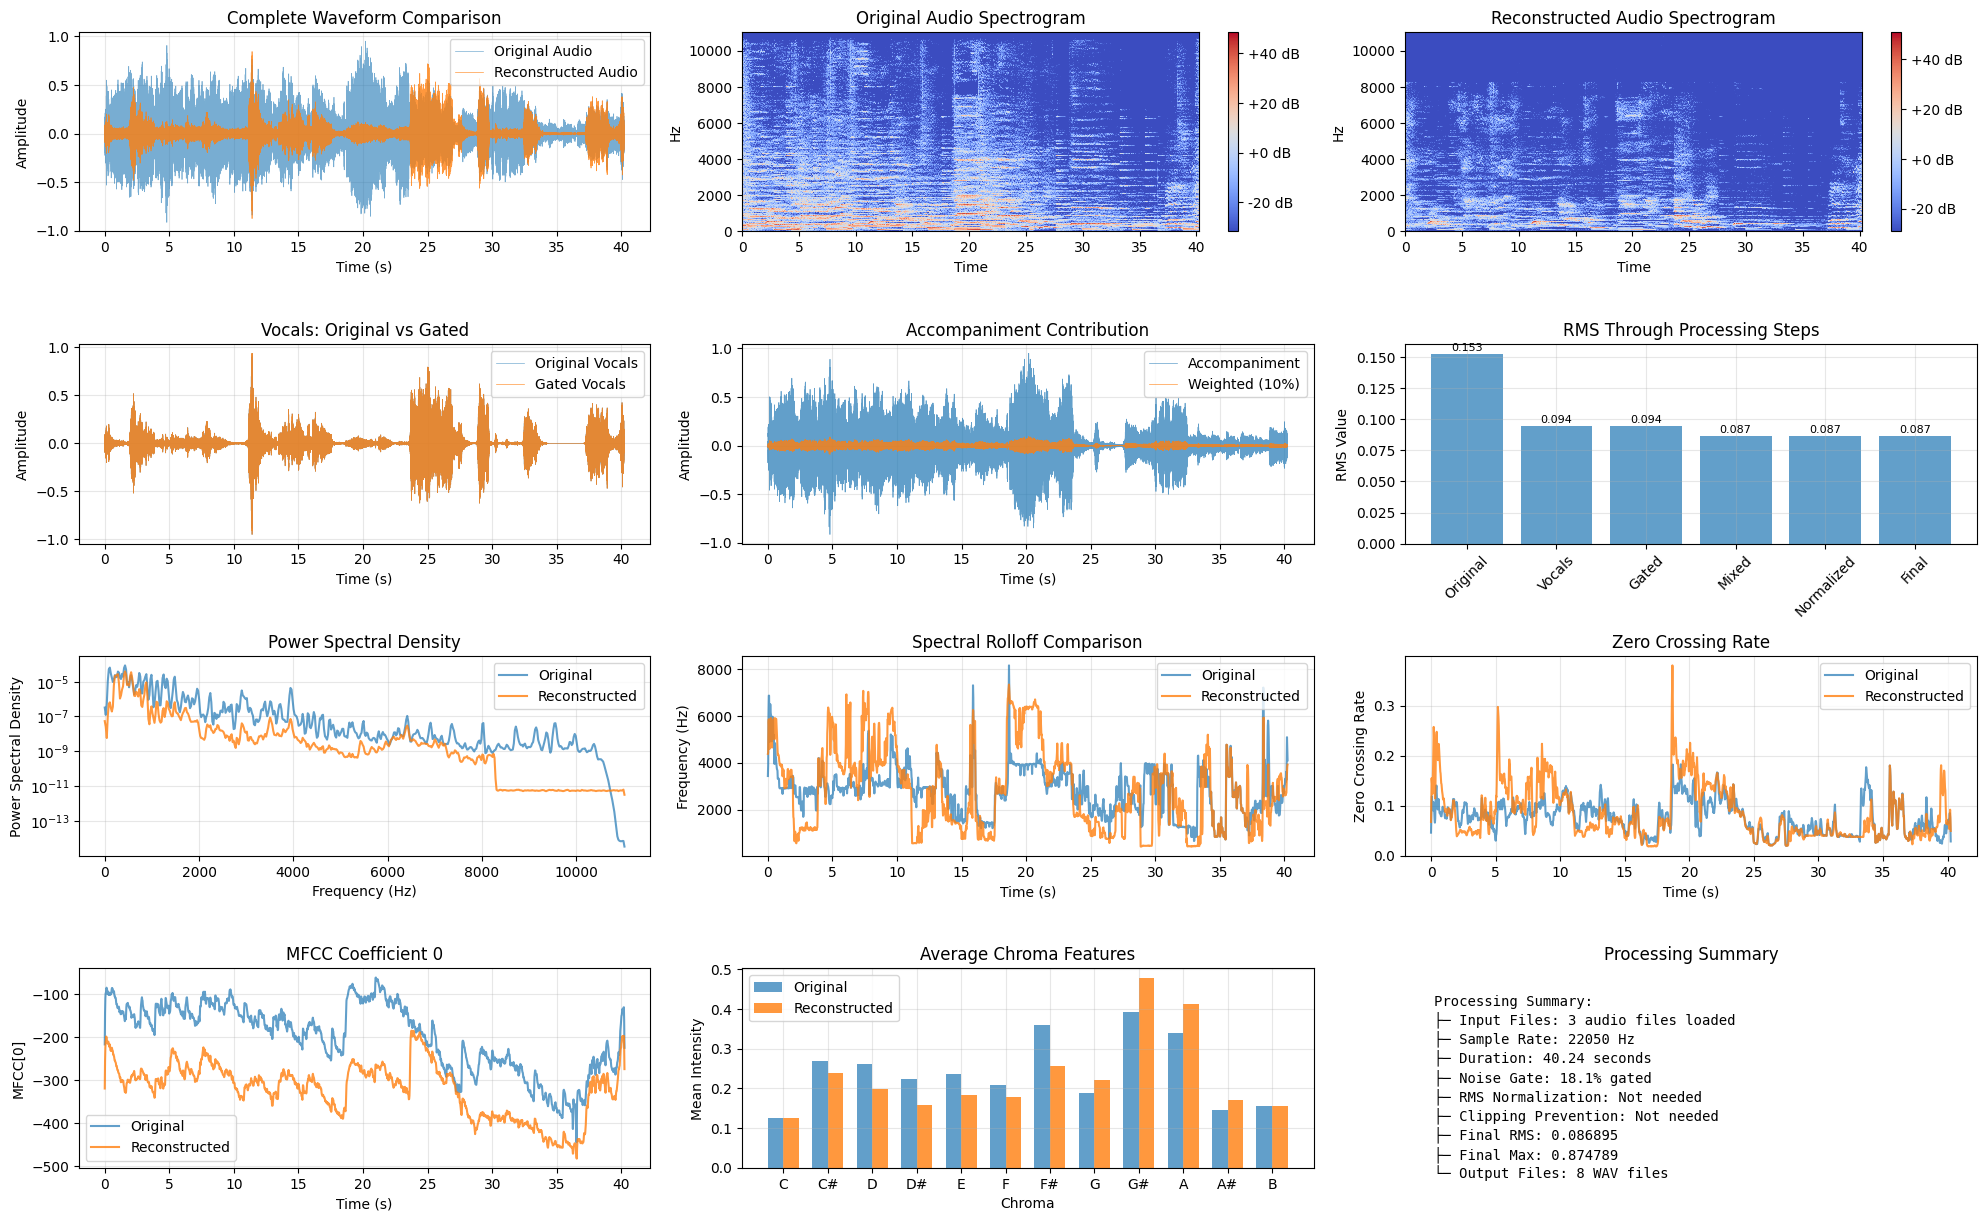


🎯 FINAL PROCESSING RESULTS
Correlation coefficient: 0.6077
Signal-to-Noise Ratio: 1.99 dB
Mean Squared Error: 0.01479441
Root Mean Squared Error: 0.12163226
Peak SNR: 17.85 dB

📁 Output Files Generated:
   1. 20250723_232154_step01_original_accompaniment.wav
   2. 20250723_232154_step01_original_audio.wav
   3. 20250723_232154_step01_original_vocals.wav
   4. 20250723_232154_step02_synced_accompaniment.wav
   5. 20250723_232154_step02_synced_vocals.wav
   6. 20250723_232154_step04_gated_vocals.wav
   7. 20250723_232154_step05_mixed_audio.wav
   8. 20250723_232154_step07_final_result.wav

📊 Visualization Files:
  1. 20250723_232154_final_comprehensive_analysis.png
  2. 20250723_232154_step03_rms_analysis.png
  3. 20250723_232154_step04_noise_gate_analysis.png
  4. 20250723_232154_step05_mixing_analysis.png
  5. 20250723_232154_step06_normalization_analysis.png
  6. 20250723_232154_step07_clipping_analysis.png

🎵 Test completed successfully!
All files saved in: output/test_reconstruct
T

In [10]:
# Export and Visualize Final Results
print("📊 Creating final summary and comprehensive analysis...")

# Create a comprehensive comparison
plt.figure(figsize=(20, 15))

# Plot 1: Complete waveform comparison
plt.subplot(5, 3, 1)
time_axis = np.linspace(0, len(reconstructed_audio)/sr, len(reconstructed_audio))
plt.plot(time_axis, original_audio, alpha=0.6, label='Original Audio', linewidth=0.5)
plt.plot(time_axis, reconstructed_audio, alpha=0.8, label='Reconstructed Audio', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Complete Waveform Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Spectrogram comparison - Original
plt.subplot(5, 3, 2)
D_orig = librosa.stft(original_audio)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_orig)), sr=sr, x_axis='time', y_axis='hz')
plt.title('Original Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot 3: Spectrogram comparison - Reconstructed
plt.subplot(5, 3, 3)
D_recon = librosa.stft(reconstructed_audio)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_recon)), sr=sr, x_axis='time', y_axis='hz')
plt.title('Reconstructed Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot 4: Component analysis
plt.subplot(5, 3, 4)
plt.plot(time_axis, vocals, alpha=0.6, label='Original Vocals', linewidth=0.5)
plt.plot(time_axis, gated_vocals, alpha=0.8, label='Gated Vocals', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Vocals: Original vs Gated')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Accompaniment contribution
plt.subplot(5, 3, 5)
plt.plot(time_axis, accompaniment, alpha=0.7, label='Accompaniment', linewidth=0.5)
plt.plot(time_axis, accompaniment * 0.1, alpha=0.8, label='Weighted (10%)', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Accompaniment Contribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Processing steps summary
plt.subplot(5, 3, 6)
steps = ['Original', 'Vocals', 'Gated', 'Mixed', 'Normalized', 'Final']
rms_steps = [
    np.sqrt(np.mean(original_audio**2)),
    np.sqrt(np.mean(vocals**2)), 
    np.sqrt(np.mean(gated_vocals**2)),
    np.sqrt(np.mean((gated_vocals * 0.9 + accompaniment * 0.1)**2)),
    final_rms if normalization_applied else np.sqrt(np.mean(reconstructed_audio**2)),
    final_rms
]
bars = plt.bar(steps, rms_steps, alpha=0.7)
plt.ylabel('RMS Value')
plt.title('RMS Through Processing Steps')
plt.xticks(rotation=45)
for bar, value in zip(bars, rms_steps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 7: Frequency response comparison
plt.subplot(5, 3, 7)
from scipy import signal
f_orig, Pxx_orig = signal.welch(original_audio, sr, nperseg=1024)
f_recon, Pxx_recon = signal.welch(reconstructed_audio, sr, nperseg=1024)
plt.semilogy(f_orig, Pxx_orig, alpha=0.7, label='Original')
plt.semilogy(f_recon, Pxx_recon, alpha=0.8, label='Reconstructed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 8: Spectral rolloff comparison
plt.subplot(5, 3, 8)
rolloff_orig = librosa.feature.spectral_rolloff(y=original_audio, sr=sr)[0]
rolloff_recon = librosa.feature.spectral_rolloff(y=reconstructed_audio, sr=sr)[0]
time_frames = librosa.frames_to_time(range(len(rolloff_orig)), sr=sr)
plt.plot(time_frames, rolloff_orig, alpha=0.7, label='Original')
plt.plot(time_frames, rolloff_recon, alpha=0.8, label='Reconstructed')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Rolloff Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 9: Zero crossing rate
plt.subplot(5, 3, 9)
zcr_orig = librosa.feature.zero_crossing_rate(original_audio)[0]
zcr_recon = librosa.feature.zero_crossing_rate(reconstructed_audio)[0]
time_frames = librosa.frames_to_time(range(len(zcr_orig)), sr=sr)
plt.plot(time_frames, zcr_orig, alpha=0.7, label='Original')
plt.plot(time_frames, zcr_recon, alpha=0.8, label='Reconstructed')
plt.xlabel('Time (s)')
plt.ylabel('Zero Crossing Rate')
plt.title('Zero Crossing Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 10: MFCC comparison (first coefficient)
plt.subplot(5, 3, 10)
mfcc_orig = librosa.feature.mfcc(y=original_audio, sr=sr, n_mfcc=13)
mfcc_recon = librosa.feature.mfcc(y=reconstructed_audio, sr=sr, n_mfcc=13)
time_frames = librosa.frames_to_time(range(mfcc_orig.shape[1]), sr=sr)
plt.plot(time_frames, mfcc_orig[0], alpha=0.7, label='Original')
plt.plot(time_frames, mfcc_recon[0], alpha=0.8, label='Reconstructed')
plt.xlabel('Time (s)')
plt.ylabel('MFCC[0]')
plt.title('MFCC Coefficient 0')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 11: Chroma features
plt.subplot(5, 3, 11)
chroma_orig = np.mean(librosa.feature.chroma_stft(y=original_audio, sr=sr), axis=1)
chroma_recon = np.mean(librosa.feature.chroma_stft(y=reconstructed_audio, sr=sr), axis=1)
chroma_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
x = np.arange(len(chroma_notes))
width = 0.35
plt.bar(x - width/2, chroma_orig, width, alpha=0.7, label='Original')
plt.bar(x + width/2, chroma_recon, width, alpha=0.8, label='Reconstructed')
plt.xlabel('Chroma')
plt.ylabel('Mean Intensity')
plt.title('Average Chroma Features')
plt.xticks(x, chroma_notes)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 12: Processing summary statistics
plt.subplot(5, 3, 12)
stats_text = f"""
Processing Summary:
├─ Input Files: 3 audio files loaded
├─ Sample Rate: {sr} Hz
├─ Duration: {len(original_audio)/sr:.2f} seconds
├─ Noise Gate: {percentage_gated:.1f}% gated
├─ RMS Normalization: {'Applied' if normalization_applied else 'Not needed'}
├─ Clipping Prevention: {'Applied' if clipping_applied else 'Not needed'}
├─ Final RMS: {final_rms:.6f}
├─ Final Max: {final_max:.6f}
└─ Output Files: {len([f for f in os.listdir(output_dir) if f.endswith('.wav')])} WAV files
"""
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace')
plt.axis('off')
plt.title('Processing Summary')

plt.tight_layout()
plt.savefig(f"{output_dir}/{timestamp}_final_comprehensive_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Calculate and display final metrics
print("\n" + "="*60)
print("🎯 FINAL PROCESSING RESULTS")
print("="*60)

# Correlation analysis
correlation_coeff = np.corrcoef(original_audio, reconstructed_audio)[0, 1]
print(f"Correlation coefficient: {correlation_coeff:.4f}")

# Signal-to-Noise Ratio (if we consider difference as noise)
signal_power = np.mean(original_audio**2)
noise_power = np.mean((original_audio - reconstructed_audio)**2)
snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
print(f"Signal-to-Noise Ratio: {snr:.2f} dB")

# Mean Squared Error
mse = np.mean((original_audio - reconstructed_audio)**2)
print(f"Mean Squared Error: {mse:.8f}")

# Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.8f}")

# Peak Signal-to-Noise Ratio
max_val = np.max(np.abs(original_audio))
psnr = 20 * np.log10(max_val / rmse) if rmse > 0 else float('inf')
print(f"Peak SNR: {psnr:.2f} dB")

print("\n📁 Output Files Generated:")
wav_files = [f for f in os.listdir(output_dir) if f.endswith('.wav')]
png_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

for i, wav_file in enumerate(sorted(wav_files), 1):
    print(f"  {i:2d}. {wav_file}")

print(f"\n📊 Visualization Files:")
for i, png_file in enumerate(sorted(png_files), 1):
    print(f"  {i}. {png_file}")

print(f"\n🎵 Test completed successfully!")
print(f"All files saved in: {output_dir}")
print(f"Total processing steps: 7")
print(f"Timestamp: {timestamp}")